# Imports

### Installs

In [169]:
# !pip install transformers==4.2.2
# !pip install Unidecode
# !pip install word2number
# !pip install contractions
# !pip install bs4

### Libraries

In [170]:
# Model
import torch
import transformers
import sklearn

# NLP preprocess
from bs4 import BeautifulSoup
import spacy
import unidecode
from word2number import w2n
import contractions

# Data analysis
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

print(torch.__version__)
print(transformers.__version__)

1.7.0+cu101
4.2.2


### Device

In [171]:
# from google.colab import drive
# drive.mount('/content/drive')

In [172]:
torch.cuda.is_available()

True

In [173]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataset

In [174]:
df = pd.read_csv('/content/drive/MyDrive/DATASET/resabot_dataset.csv')

### Constants

In [175]:
TEXT_MAX_LENGTH = 256
BATCH_SIZE = 2
LEARNING_RATE = 0.0001
EPOCHS = 20
TEST_SIZE = 0.2

# Exploratory Data Analysis

In [176]:
df.head(10)

,sequence,intent
0,Hello !,smalltalk_greetings_hello
1,Hi there,smalltalk_greetings_hello
2,Hey,smalltalk_greetings_hello
3,Greetings,smalltalk_greetings_hello
4,Good afternoon,smalltalk_greetings_hello
5,Hi,smalltalk_greetings_hello
6,Howdy,smalltalk_greetings_hello
7,I greet you,smalltalk_greetings_hello
8,Hello there,smalltalk_greetings_hello
9,Hello again,smalltalk_greetings_hello


### Duplicates and missing

In [177]:
df.shape

(86, 2)

**Observation**: 8 duplicates dropped, no missing values.

In [178]:
df.drop_duplicates(inplace=True)
df.shape

(86, 2)

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86 entries, 0 to 85
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  86 non-null     object
 1   intent    86 non-null     object
dtypes: object(2)
memory usage: 2.0+ KB


### Labels distribution

In [180]:
df['intent'].value_counts()

longtalk_make_reservation     21
smalltalk_confirmation_yes    13
smalltalk_confirmation_no     11
smalltalk_greetings_hello     10
longtalk_accomodations        10
longtalk_pets                  7
longtalk_internet              7
longtalk_price                 7
Name: intent, dtype: int64

**Observation**: They are X categories, unbalanced. The most observed is *X*, and the least one is *X*.

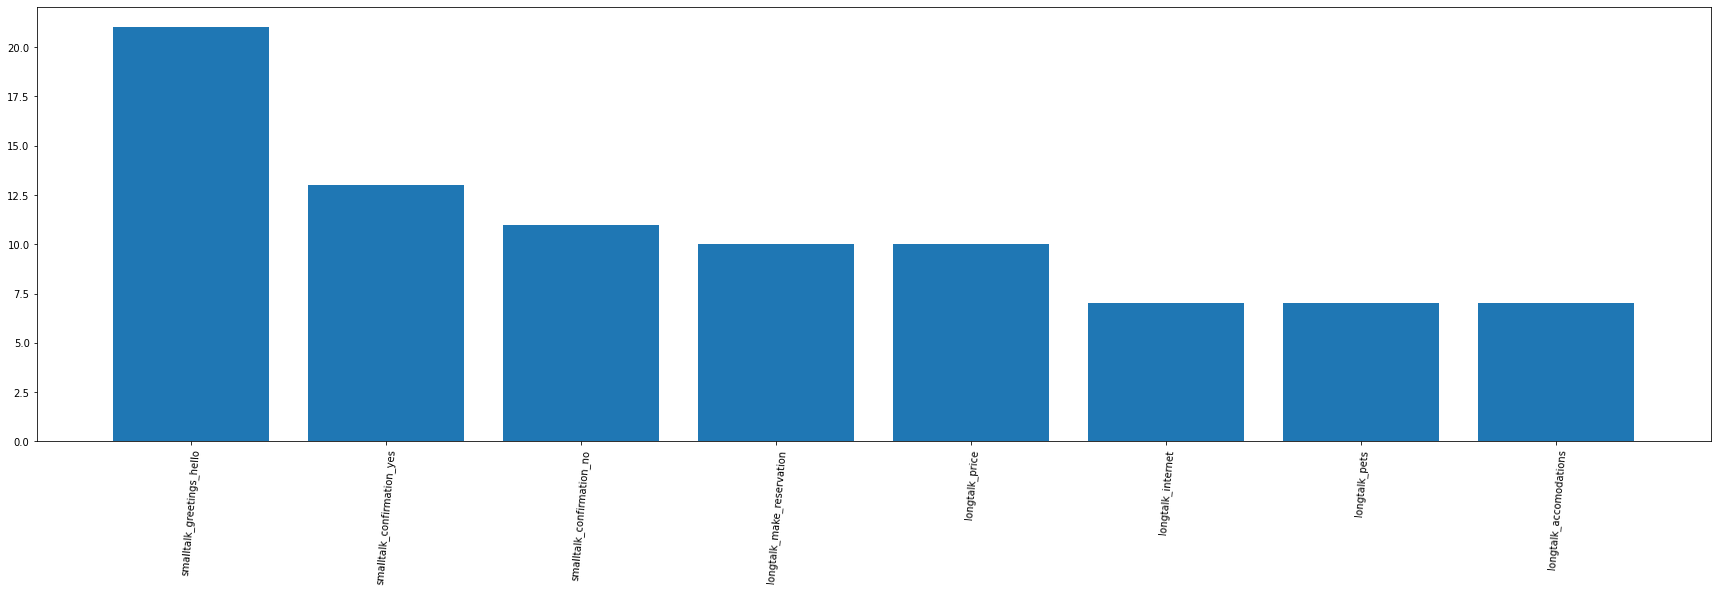

In [181]:
labels = df['intent'].unique()
count = df['intent'].value_counts().values

plt.figure(figsize=(30,8))
plt.bar(labels, count)
plt.xticks(rotation=85)
plt.show()

# Document preprocessing

### Remove HTML5 tag

In [182]:
def strip_html_tags(text: str):
    """Remove html tags from text."""

    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text(separator=" ")

    return stripped_text

### Expand contractions

In [183]:
def expand_contractions(text: str):
    """Expand shortened words, e.g. 'don't' to 'do not'."""

    text = contractions.fix(text)
    return text

### Remove accents

In [184]:
def remove_accented_chars(text):
    """Remove accented characters from text, e.g. café."""

    text = unidecode.unidecode(text)
    return text

### Remove whitespace

In [185]:
def remove_whitespace(text: str):
    """Remove extra whitespaces from text."""

    text = text.strip()
    return " ".join(text.split())

### Limit to 256 words

In [186]:
def limit_n_words(text: str, limit: int = TEXT_MAX_LENGTH):
    """Limit a text to 256 words."""

    text = text.split()[:limit]
    return " ".join(text)

### Cleaning

Assemble all functions together

In [187]:
def text_preprocessing(text: str):

    # Preprocess
    text = strip_html_tags(text)
    text = remove_whitespace(text)
    text = remove_accented_chars(text)
    text = expand_contractions(text)
    text = limit_n_words(text)
    text = text.lower()

    return text

In [188]:
df['sequence'] = df['sequence'].apply(text_preprocessing)

In [189]:
df.head(10)

,sequence,intent
0,hello !,smalltalk_greetings_hello
1,hi there,smalltalk_greetings_hello
2,hey,smalltalk_greetings_hello
3,greetings,smalltalk_greetings_hello
4,good afternoon,smalltalk_greetings_hello
5,hi,smalltalk_greetings_hello
6,how do you,smalltalk_greetings_hello
7,i greet you,smalltalk_greetings_hello
8,hello there,smalltalk_greetings_hello
9,hello again,smalltalk_greetings_hello


# Label encoding

Label encode

In [190]:
# Set to categorical
df['intent'] = df['intent'].astype('category')

In [191]:
# Create a category number
df["id_label"] = df["intent"].cat.codes

In [192]:
df.head()

,sequence,intent,id_label
0,hello !,smalltalk_greetings_hello,7
1,hi there,smalltalk_greetings_hello,7
2,hey,smalltalk_greetings_hello,7
3,greetings,smalltalk_greetings_hello,7
4,good afternoon,smalltalk_greetings_hello,7


Save dictionary label

In [193]:
labels = df.set_index('id_label')['intent'].to_dict()

In [194]:
labels

{0: 'longtalk_accomodations',
 1: 'longtalk_internet',
 2: 'longtalk_make_reservation',
 3: 'longtalk_pets',
 4: 'longtalk_price',
 5: 'smalltalk_confirmation_no',
 6: 'smalltalk_confirmation_yes',
 7: 'smalltalk_greetings_hello'}

In [195]:
with open('labels.pickle', 'wb') as handle:
    pickle.dump(labels, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Dataset creation

### Train/test split

Split the dataset into train and test subsets.

In [196]:
X = df['sequence']
y = df["id_label"]

In [197]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

Save the labels as tensors

In [198]:
train_labels = torch.tensor(y_train.values, dtype=torch.long, device=device)

In [199]:
test_labels = torch.tensor(y_test.values, dtype=torch.long, device=device)

### Tokenization

Get the text into vectors.

In [200]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [201]:
# Train encoder

train_encoder = tokenizer.batch_encode_plus(
    X_train,
    padding='max_length',
    max_length=TEXT_MAX_LENGTH,
    return_attention_mask=True,
    return_tensors='pt'
)

In [202]:
# Test encoder

test_encoder = tokenizer.batch_encode_plus(
    X_test,
    padding='max_length',
    max_length=TEXT_MAX_LENGTH,
    return_attention_mask=True,
    return_tensors='pt'
)

In [203]:
train_encoder['input_ids']

tensor([[ 101, 2079, 2017,  ...,    0,    0,    0],
        [ 101, 2024, 2045,  ...,    0,    0,    0],
        [ 101, 2009, 2003,  ...,    0,    0,    0],
        ...,
        [ 101, 1045, 2031,  ...,    0,    0,    0],
        [ 101, 3100,  102,  ...,    0,    0,    0],
        [ 101, 1045, 2342,  ...,    0,    0,    0]])

### Torch dataset

Create a torch dataset

In [204]:
from torch.utils.data import TensorDataset

In [205]:
class CustomDataset(torch.utils.data.Dataset):
  
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]).to(device) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encoder, train_labels)
val_dataset = CustomDataset(test_encoder, test_labels)

In [206]:
train_dataset[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0'),
 'input_ids': tensor([ 101, 2079, 2017, 2031, 2151, 3313, 4734, 2800, 2023, 5353, 1029,  102,
  

In [207]:
# train_seq = train_encoder['input_ids']
# train_mask = train_encoder['attention_mask']

# train = TensorDataset(train_seq, train_mask, train_labels)

In [208]:
# test_seq = test_encoder['input_ids']
# test_mask = test_encoder['attention_mask']

# test = TensorDataset(test_seq, test_mask, test_labels)

# Model

### Creation

In [209]:
model = transformers.BertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="bert-base-uncased",
    num_labels=len(labels)
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [210]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Training function

Training argument

In [211]:
training_argument = transformers.TrainingArguments(
    output_dir='./results',
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    logging_dir='./logs', 
)


In [212]:
type(training_argument)


transformers.training_args.TrainingArguments

Training evaluation

In [213]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

Merge the above classes to a trainer object

In [214]:
trainer = transformers.Trainer(
    model,
    training_argument,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,   
)

In [215]:
trainer.get_eval_dataloader()

In [216]:
type(trainer)

transformers.trainer.Trainer

### Train

In [217]:
trainer.train()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Step,Training Loss
500,0.269800


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


TrainOutput(global_step=680, training_loss=0.19870624704396023, metrics={'train_runtime': 94.8616, 'train_samples_per_second': 7.168, 'total_flos': 228716871352320, 'epoch': 20.0})

### Evaluate

In [218]:
trainer.evaluate()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


{'epoch': 20.0,
 'eval_accuracy': 1.0,
 'eval_f1': 1.0,
 'eval_loss': 0.010037661530077457,
 'eval_precision': 1.0,
 'eval_recall': 1.0,
 'eval_runtime': 0.3108,
 'eval_samples_per_second': 57.921}

In [219]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

#### Unique test

In [220]:
text = "you are a bad bot"

In [221]:
import torch
sample_inputs = tokenizer(text, return_tensors="pt").to(device)

In [222]:
outputs = model(
    input_ids=sample_inputs.input_ids,
    token_type_ids=None, 
    attention_mask=sample_inputs.attention_mask
  )

In [223]:
_, preds = torch.max(outputs[0], dim=1)
num_label = preds[0].item()

In [224]:
labels[num_label]

'longtalk_pets'

#### Multiple test

In [225]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([], device=device)
    for batch in loader:
        input_ids, token_type_ids, attention_mask, labels = batch.values()

        preds = model(
            input_ids=input_ids,
            token_type_ids=None,
            attention_mask=attention_mask
        )
        print(type(preds[0]))
        all_preds = torch.cat((all_preds, preds[0]),dim=0)
    return all_preds

In [226]:
with torch.no_grad():
    test_preds = get_all_preds(model, trainer.get_eval_dataloader())
    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [227]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

prediction = test_preds.argmax(dim=1).to('cpu')

# Math the metrics score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, prediction, average='micro')
acc = accuracy_score(y_test, prediction)
conf_matrix = confusion_matrix(y_test, prediction)

In [228]:
conf_matrix

array([[1, 0, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 4, 0],
       [0, 0, 0, 0, 0, 0, 0, 2]])

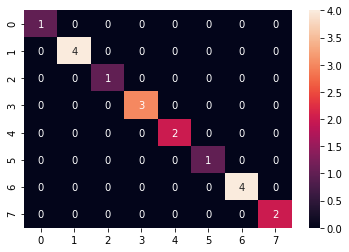

In [229]:
import seaborn as sns
sns.heatmap(conf_matrix, annot=True)

In [231]:
# import torch
# torch.save(model, 'resa_model_100')